### Parameter tuning in XGBoost using Gridsearch CV on normalized exoplanet search data.

The first pass is executed on non Fast Fourier Transformed Data, with the train/test split consistent with the Kaggle competition. The results were poor with a 28% accuracy. With Fast Fourier Transformation we get a stronger result.

Imports

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.ndimage 
import xgboost as xg
from imblearn.over_sampling import SMOTE #For imbalanced datasets
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from imblearn.pipeline import make_pipeline, Pipeline

Import pre-split data and set up train and test

In [34]:
train = pd.read_csv('exoTrain.csv')
test = pd.read_csv('exoTest.csv')

In [35]:
X_train = train.drop('LABEL', axis=1)
y_train = train.LABEL
X_test = test.drop('LABEL', axis=1)
y_test = test.LABEL

Define normalize function and apply to train and test dataset

In [7]:
def normal(X):
    Y= (X-np.mean(X))/(np.max(X)-np.min(X))
    return Y

In [36]:
X_train= X_train.apply(normal,axis=1)

In [37]:
X_test= X_test.apply(normal,axis=1)

Plotting out the normalized light flux shows a pattern of dips. If there are 3 or more dips with the same spacing that makes an exoplanet transit likely. These were taken over an 80 day period every 30 mins.

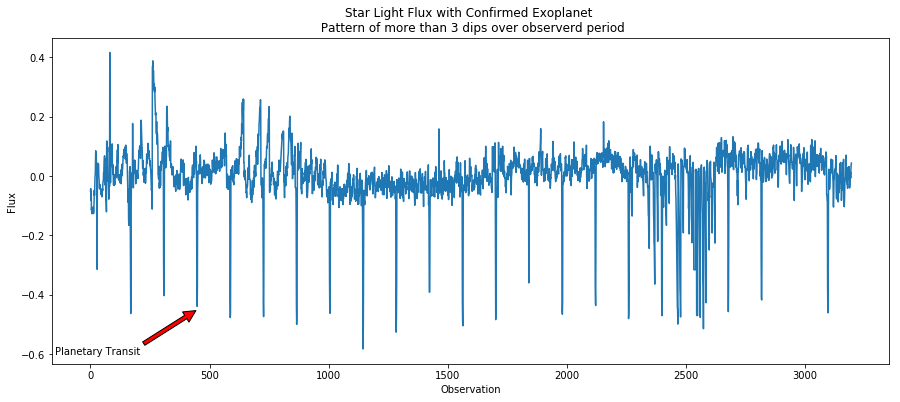

In [70]:
Y = X_train.iloc[1]
X = np.arange(len(Y)) 

plt.figure(figsize=(15,6))
plt.annotate('Planetary Transit', xy=(450, -.45), xytext=(-150, -.6),arrowprops=dict(facecolor='red', shrink=0.03),)
plt.ylabel('Flux')
plt.xlabel('Observation')
plt.title('Star Light Flux with Confirmed Exoplanet \n Pattern of more than 3 dips over observerd period')
plt.plot(X, Y)

plt.show()


The above plot has 23 transits, which equates to an exoplanet with an orbital period of 3-4 days. 

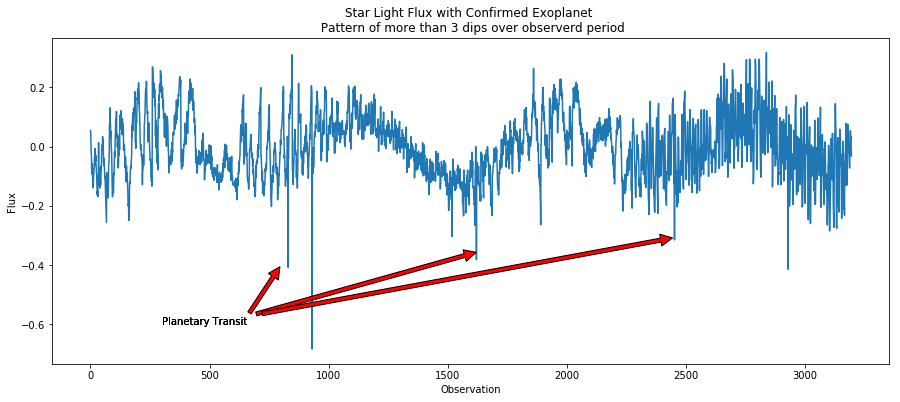

In [82]:

Y = X_train.iloc[0]
X = np.arange(len(Y)) 
plt.figure(figsize=(15,6))
plt.annotate('Planetary Transit', xy=(800, -.4), xytext=(300, -.6),arrowprops=dict(facecolor='red', shrink=0.03),)
plt.annotate('Planetary Transit', xy=(1650, -.35), xytext=(300, -.6),arrowprops=dict(facecolor='red', shrink=0.03),)
plt.annotate('Planetary Transit', xy=(2500, -.3), xytext=(300, -.6),arrowprops=dict(facecolor='red', shrink=0.03),)
plt.ylabel('Flux')
plt.xlabel('Observation')
plt.title('Star Light Flux with Confirmed Exoplanet \n Pattern of more than 3 dips over observerd period')
plt.plot(X, Y)
plt.show()

The above plot has 3 similar transits, which equates to an exoplanet with an orbital period of about 26 days.

---


Instatiate SMOTE to assist with the imbalanced dataset.

In [14]:
sm = SMOTE(ratio = 'auto')

Define the functions

In [21]:
class EstimatorSelectionHelper:
    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}
    
    def fit(self, X, y, cv=3, n_jobs=1, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            sm = SMOTE(ratio = 'auto')
            model = self.models[key]
            params = self.params[key]
            pipeline = Pipeline([('sm',sm), ('model',model)]) #create a PIPELINE to apply SMOTE
            kf = StratifiedKFold(n_splits=10)
            gs = GridSearchCV(pipeline, params, cv=cv, n_jobs=n_jobs, 
                              verbose=verbose, scoring=scoring, refit=refit)
            gs.fit(X,y)
            self.grid_searches[key] = gs    
    
    def score_summary(self, sort_by='min_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores)
                 #'std_score': std(scores), Uncomment later
            }
            return pd.Series({**params,**d}) #Fixed for Python 3
                      
        rows = [row(k, gsc.cv_validation_scores, gsc.parameters) 
                     for k in self.keys
                     for gsc in self.grid_searches[k].grid_scores_]
        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False) #Fixed for Python 3 sort_values
        
        columns = ['estimator', 'min_score', 'max_score']
         #, 'max_score', 'std_score'] uncomment
        columns = columns + [c for c in df.columns if c not in columns]
        
        return df[columns]

Create a dictionary of the models

In [23]:
models1 = { 
    
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'XGBClassifier': xg.XGBClassifier(),

}

params1 = { 
    'RandomForestClassifier': { "model__n_estimators": [10, 18, 22],
              "model__max_depth": [3, 5],
              "model__min_samples_split": [15, 20],
              "model__min_samples_leaf": [5, 10, 20], },
    'AdaBoostClassifier':  { "model__n_estimators": [10, 18, 22],
                            },
              
    'XGBClassifier': { 'model__n_estimators': [1000], 'model__learning_rate': [1.0],'model__max_depth':range(3,10,2),
 'model__min_child_weight':range(1,6,2) },

}

In [25]:
f1_scorer = make_scorer(f1_score, pos_label=2)

In [26]:
helper = EstimatorSelectionHelper(models1, params1)
helper.fit(X_train, y_train, scoring=f1_scorer, n_jobs=-1)

Running GridSearchCV for RandomForestClassifier.
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  1.5min finished


Running GridSearchCV for AdaBoostClassifier.
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:  1.7min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  2.6min finished


Running GridSearchCV for XGBClassifier.
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 36.2min finished


In [27]:
helper.score_summary(sort_by='max_score')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


,estimator,min_score,max_score,mean_score,model__learning_rate,model__max_depth,model__min_child_weight,model__min_samples_leaf,model__min_samples_split,model__n_estimators
35,RandomForestClassifier,0.0714286,0.285714,0.143739,NaN,5,NaN,20,20,22
23,RandomForestClassifier,0.0625,0.272727,0.148779,NaN,5,NaN,5,20,22
44,XGBClassifier,0.0869565,0.272727,0.154982,1,5,5,NaN,NaN,1000
31,RandomForestClassifier,0.0740741,0.272727,0.150688,NaN,5,NaN,20,15,18
34,RandomForestClassifier,0.0666667,0.25,0.142593,NaN,5,NaN,20,20,18
21,RandomForestClassifier,0.0526316,0.24,0.143206,NaN,5,NaN,5,20,10
11,RandomForestClassifier,0.0789474,0.24,0.139319,NaN,3,NaN,10,20,22
22,RandomForestClassifier,0.0666667,0.230769,0.154701,NaN,5,NaN,5,20,18
25,RandomForestClassifier,0.0689655,0.222222,0.147063,NaN,5,NaN,10,15,18
2,RandomForestClassifier,0.0645161,0.210526,0.120355,NaN,3,NaN,5,15,22


Training the algorithms with the highest max-score for each training set.
We use SMOTE on each training set and train the algorithm, with its respective parameters, that got the highest score on the respective training set.

In [28]:
sm = SMOTE(ratio =1.0,random_state=123 )
X_r, y_r = sm.fit_sample(X_train, y_train)
print (y_train.value_counts(), np.bincount(y_r))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


1    5050
2      37
Name: LABEL, dtype: int64 [   0 5050 5050]


In [29]:
model = xg.XGBClassifier(n_estimators = 1000, learning_rate= 1.0, max_depth= 9, min_child_weight = 3,seed=123)

model.fit(X_r, y_r)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
f2_score = f1_score(y_test, predictions,pos_label = 2)
print("f1_score: %.2f%%" % (f2_score * 100.0))

f1_score: 0.00%


---

Fast Fourier Transform

Using the fft function (Fast Fourier Transformation) to clean up the overlaid signals.

In [84]:
def fourier(X):
    Y = scipy.fft(X, n=X.size)
    return np.abs(Y)

In [85]:
X_train = X_train.apply(fourier,axis=1)
X_test = X_test.apply(fourier,axis=1)

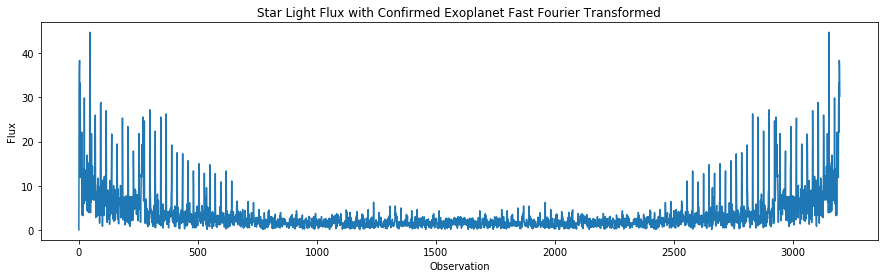

In [97]:
Y = X_train.iloc[1]
X = np.arange(len(Y)) 
plt.figure(figsize=(15,4))
plt.ylabel('Flux')
plt.xlabel('Observation')
plt.title('Star Light Flux with Confirmed Exoplanet Fast Fourier Transformed')
plt.plot(X, Y)
plt.show()

With this symmetry we can reduce the number of features by half

In [96]:
len(X_train.iloc[1])/2

1598.5

Drop the first 1600 (half) features

In [98]:
X_train = X_train.drop(X_train.columns[1600:], axis=1)
X_test = X_test.drop(X_test.columns[1600:], axis=1)

Apply the normalizing function

In [102]:
X_train= X_train.apply(normal,axis=1)
X_test= X_test.apply(normal,axis=1)

What does the new flux observation data now look like?

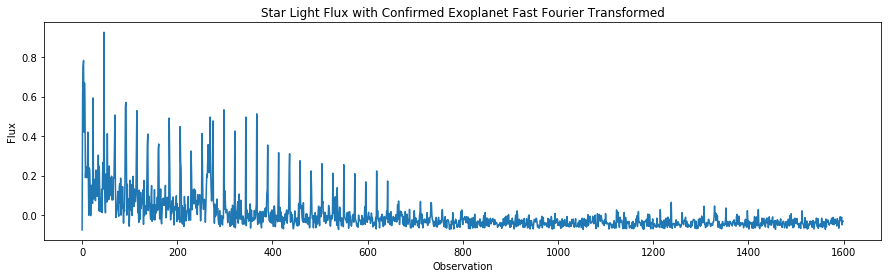

In [104]:
Y = X_train.iloc[1]
X = np.arange(len(Y)) 
plt.figure(figsize=(15,4))
plt.ylabel('Flux')
plt.xlabel('Observation')
plt.title('Star Light Flux with Confirmed Exoplanet Fast Fourier Transformed')
plt.plot(X, Y)
plt.show()

In [99]:
sm = SMOTE(ratio = 'auto')

In [105]:
X_train= X_train.as_matrix()
X_test= X_test.as_matrix()

In [106]:
f1_scorer = make_scorer(f1_score, pos_label=2)

In [107]:
helper = EstimatorSelectionHelper(models1, params1)
helper.fit(X_train, y_train, scoring=f1_scorer, n_jobs=-1)

Running GridSearchCV for RandomForestClassifier.
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   57.4s finished


Running GridSearchCV for AdaBoostClassifier.
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   49.7s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.1min finished


Running GridSearchCV for XGBClassifier.
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 17.8min finished


In [108]:
helper.score_summary(sort_by='max_score')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


,estimator,min_score,max_score,mean_score,model__learning_rate,model__max_depth,model__min_child_weight,model__min_samples_leaf,model__min_samples_split,model__n_estimators
48,XGBClassifier,0.315789,0.666667,0.538012,1,9,1,NaN,NaN,1000
42,XGBClassifier,0.444444,0.666667,0.555556,1,5,1,NaN,NaN,1000
46,XGBClassifier,0.2,0.636364,0.412121,1,7,3,NaN,NaN,1000
50,XGBClassifier,0.421053,0.631579,0.517544,1,9,5,NaN,NaN,1000
20,RandomForestClassifier,0.238095,0.631579,0.423225,NaN,5,NaN,5,15,22
14,RandomForestClassifier,0.142857,0.631579,0.411992,NaN,3,NaN,20,15,22
45,XGBClassifier,0.421053,0.6,0.522169,1,7,1,NaN,NaN,1000
1,RandomForestClassifier,0.126316,0.56,0.346419,NaN,3,NaN,5,15,18
44,XGBClassifier,0.222222,0.56,0.401092,1,5,5,NaN,NaN,1000
39,XGBClassifier,0.416667,0.555556,0.499513,1,3,1,NaN,NaN,1000


The highest score is now .67

In [110]:
model = xg.XGBClassifier(n_estimators = 1000, learning_rate= 1.0, max_depth= 9, min_child_weight = 3,seed=123)

model.fit(X_r, y_r)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
f2_score = f1_score(y_test, predictions,pos_label = 2)
print("f1_score: %.2f%%" % (f2_score * 100.0))

f1_score: 57.14%


In [90]:
X_train_1 = X_train.drop(X_train.columns[1:100], axis=1)

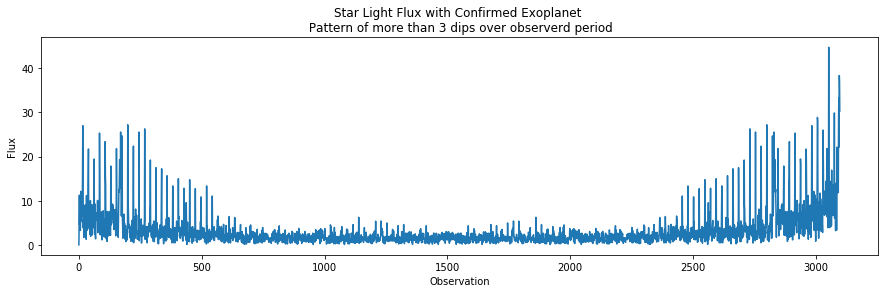

In [93]:
Y = X_train_1.iloc[1]
X = np.arange(len(Y)) 

plt.figure(figsize=(15,4))
plt.ylabel('Flux')
plt.xlabel('Observation')
plt.title('Star Light Flux with Confirmed Exoplanet \n Pattern of more than 3 dips over observerd period')
plt.plot(X, Y)

plt.show()